# An exploration of my Python Imports over time

Explore my gists downloaded from a [previous post about doit](https://tonyfast.github.io/clog/clog/2017-09-21-Automate-Gist-Collection-With-Doit.html).  This notebook parses each of the cells looking for imports.  Ending with a historical plot of package over time.

In [66]:
%matplotlib inline
from IPython.display import *; from ast import *; from multipledispatch import dispatch; from nbformat.v4 import *; from nbconvert import *; import nbformat; from wip.clsindex import PathIndex; from pandas import *

In [36]:
@dispatch(list)
def _recurse(_): return {i:  _recurse(v) for i, v in enumerate(_)}

@dispatch(dict)
def _recurse(_): return {k: _recurse(_[k]) for k in _}

@dispatch(AST)
def _recurse(_):
    return _ and {'type': type(_), **{k: _recurse(v) for k, v in vars(_).items()}} or _

@dispatch(object)
def _recurse(_): return _

In [37]:
def scrape(sample=sample):
    scraped = dict(imports=[], magics=[])
    try:
        dicts = _recurse(
            parse(exporters.PythonExporter().from_notebook_node(
                new_notebook(cells=[new_code_cell(sample)])
            )[0]))
        def _values(object):
            if hasattr(object, 'items'):
                if 'type' in object:
                    type = object['type']
                    if type is Expr and 'func' in object['value'] and 'attr' in object['value']['func']:
                        if object['value']['func']['attr'] == 'magic':
                            scraped['magics'].append(object['value']['args'][0]['s'])
                    if type is ImportFrom:
                        scraped['imports'].append(object['module'])
                    if type is Import:
                        scraped['imports'].extend(
                            [_['name'] for _ in object['names'].values()])

                return {k: _values(v) for k, v in object.items()}
            return object
        _values(dicts)
        
    except:
        pass
    return scraped

In [38]:
def loadnb(path):
    try:
        object = __import__('json').loads(path.read_text())
    except:
        return dict()
    if 'cells' in object:
        return DataFrame([
            scrape(
                '\n'.join(_['source']) if isinstance(_['source'], list) else _['source']
            )
            for _ in object['cells']
        ])['imports'].apply(Series).stack().drop_duplicates().tolist()
    return []

In [11]:
files = PathIndex('/Users/tonyfast/gists/').rglob('*.ipynb')

In [39]:
ts = read_csv('/Users/tonyfast/gists/master.csv').set_index('id')['created_at'].pipe(to_datetime).loc[ids].drop_duplicates()

In [40]:
imports = Series(files.map(loadnb), files).apply(Series).set_index(
    Index(s.index.parent.parent.map(lambda x: x.name))
).unstack().reset_index(0, drop=True).dropna()

In [75]:
df = imports.to_frame('imports').set_index(ts.loc[imports.index.tolist()].values).imports.str.split('.', 1, expand=True)[0]

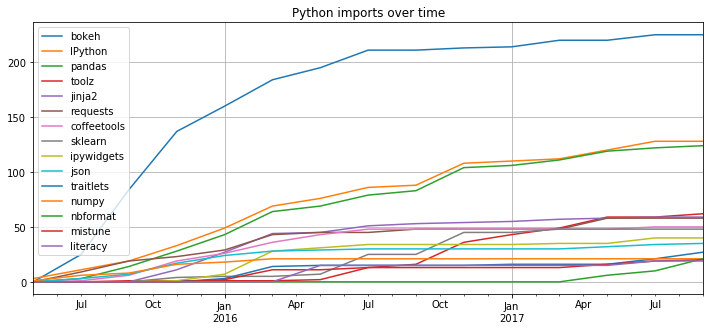

In [90]:
df.groupby(TimeGrouper('2M')).value_counts().unstack().pipe(
    lambda df: df.groupby(df.columns.str.split('.', 1).map(lambda x: x[0]), axis=1).sum()
).pipe(
    lambda df: df[df.sum().sort_values().index[::-1]]
).fillna(0).pipe(lambda df: df[df.columns[:15]]).cumsum().plot(figsize=(12, 5), grid=True, title='Python imports over time');

In [91]:
aggs = df.value_counts().sort_values(ascending=False)

In [92]:
_ = aggs[aggs.gt(3)].to_frame()
display(*[HTML(_.iloc[i*12:(i+1)*12].T.to_html()) for i in range(1+len(_)//12)])

,bokeh,IPython,pandas,toolz,jinja2,requests,coffeetools,sklearn,ipywidgets,json,traitlets,nbformat
0,225,128,124,62,59,58,50,48,40,35,27,21


,numpy,mistune,literacy,nbconvert,yaml,blaze,os,fidget,pyquery,time,importlib,matplotlib
0,21,20,19,17,17,14,14,14,14,12,11,11


,markdown,inspect,pathlib,random,networkx,glob,odo,sys,collections,functools,io,skimage
0,10,10,9,8,8,8,7,7,7,7,6,6


,whatever4e,pyjade,geopy,typing,jinjamagic,math,builtins,multipledispatch,copy,operator,flexx,scipy
0,6,6,6,5,5,5,5,5,5,5,5,4


,stopit,git,gfm,jinja2schema,types
0,4,4,4,4,4


## Others

In [93]:
aggs[aggs.lt(4)].to_frame().index

Index(['http', 'logging', 'itertools', 'ujson', 'chain', 'qgrid', 'deap',
       'bs4', 'contextlib', 'markdownmagic', 'base64', 'luigi', 'grapefruit',
       'tqdm', 'urllib', 'lifelines', 'six', 'jibbery', 'tpot', 'hashlib',
       'dask', 're', 'decorator', 'ipytangle', 'mimetypes', 'sumpino',
       'jsonpatch', 'tempfile', 'whatever', 'setuptools', 'flask', 'lit',
       'sympy', 'shlex', 'argparse', 'elasticsearch', 'pypandoc', 'infix',
       'ast', 'plumbum', 'genson', 'enforce', 'imutils', 'repl', 'template',
       'yapf', 'upload_widget', 'datetime', 'harnesser', 'subprocess',
       'seaborn', 'forbiddenfruit', 'textblob', 'PIL', '__future__',
       'jsonschema', 'pprint', 'environment', 'wordcloud', 'fz', 'nbpresent',
       'doit', 'class_maker', 'threading', 'mistune_contrib', 'nbloader',
       'pathlib_types', 'importme2', 'magical', 'Untitled144', 'Downloads',
       'xmltodict', 'Untitled83', 'cv2', 'pyaudio', 'notebook'],
      dtype='object')